In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install the pyspark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 199 kB 65.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=fb301b9dd6284fa099b1fa15932f131448f0b6a0476bb8540f7dc8ff47abde20
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [ ]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

In [ ]:
#create Session Without Information
# create the session
conf = pyspark.SparkConf()
# create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
# read the bike data
df1 = spark.read.csv('/content/drive/MyDrive/JC-202205-citibike-tripdata.csv',header='true')
# read the weather data
df2=spark.read.csv('/content/drive/MyDrive/weather_ny_ 052022.csv',header='true')

In [ ]:
# display the bike data
df1.show(5)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+
|FC9EB68D6501F079|electric_bike|2022-05-15 14:02:06|2022-05-15 14:05:44|Hoboken Terminal ...|           HB101|    Hudson St & 4 St|         HB607|40.73593758446329|-74.03030455112457|40.74097260864355|-74.02860336005688|       member|
|932A2D5E45ACED5B|electric_bike|2022-05-13 15:30:14|2022-05-

In [ ]:
# display the wether data
df2.show(5)

+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+-------------------+-------------------+---------+----------------+--------------------+-----------------+--------------------+
|    name|  datetime|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|            sunrise|             sunset|moonphase|      conditions|         description|             icon|            stations|
+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+----------

In [ ]:
from pyspark.sql.functions import split
# splittng the date column into day using split function
df1 = df1.withColumn('d', split(df1['started_at'], '-').getItem(2))
df1 = df1.withColumn('day', split(df1['d'], ' ').getItem(0))
df1=df1.drop('d')
# display the data
df1.show(5)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+---+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|          end_lat|           end_lng|member_casual|day|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+---+
|FC9EB68D6501F079|electric_bike|2022-05-15 14:02:06|2022-05-15 14:05:44|Hoboken Terminal ...|           HB101|    Hudson St & 4 St|         HB607|40.73593758446329|-74.03030455112457|40.74097260864355|-74.02860336005688|       member| 15|
|932A2D5E45ACED5B|electric_bike|2022-05-13 1

In [ ]:
# splittng the date column into day using split function
df2 = df2.withColumn('w_day', split(df2['datetime'], '-').getItem(2))
# display the data
df2.show(5)

+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+-------------------+-------------------+---------+----------------+--------------------+-----------------+--------------------+-----+
|    name|  datetime|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|            sunrise|             sunset|moonphase|      conditions|         description|             icon|            stations|w_day|
+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+---------

In [ ]:
# join both the data based on the day
final=df1.join(df2, df1.day == df2.w_day)
# drop the day column in bike data
final=final.drop('day')
# drop the day column in bike data
final=final.drop('w_day')
# display the data
final.show(5)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+-----------------+------------------+-----------------+------------------+-------------+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+-------------------+-------------------+---------+--------------------+--------------------+-----------------+--------------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|        start_lat|         start_lng|          end_lat|           end_lng|member_casual|    name|  datetime|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|preciptype|snow|snow

In [ ]:
# save the data in csv
final.toPandas().to_csv('final.csv')

In [ ]:
# number of rideable_type on given conditions
final.groupBy("conditions").agg({'rideable_type':'count'}).sort(col("count(rideable_type)").desc()).show()

+--------------------+--------------------+
|          conditions|count(rideable_type)|
+--------------------+--------------------+
|    Partially cloudy|               42230|
|Rain, Partially c...|               17179|
|               Clear|               12034|
|      Rain, Overcast|                9039|
+--------------------+--------------------+



In [ ]:
# name of the top 5 start stations based on rideable_type
final.groupBy("start_station_name").agg({'rideable_type':'count'}).sort(col("count(rideable_type)").desc()).show(5)

+--------------------+--------------------+
|  start_station_name|count(rideable_type)|
+--------------------+--------------------+
|South Waterfront ...|                4241|
|Hoboken Terminal ...|                3785|
|       Grove St PATH|                3610|
|             Sip Ave|                2142|
|City Hall - Washi...|                2141|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# name of the top 5 end stations based on rideable_type
final.groupBy("end_station_name").agg({'rideable_type':'count'}).sort(col("count(rideable_type)").desc()).show(5)

+--------------------+--------------------+
|    end_station_name|count(rideable_type)|
+--------------------+--------------------+
|South Waterfront ...|                4266|
|Hoboken Terminal ...|                3726|
|       Grove St PATH|                3714|
|City Hall - Washi...|                2170|
|        Newport Pkwy|                2135|
+--------------------+--------------------+
only showing top 5 rows



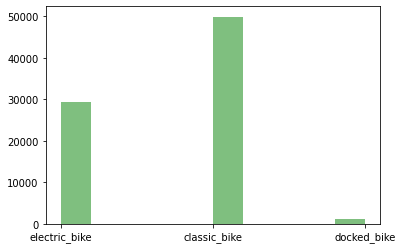

In [ ]:
#  rideable types bar graph plot
d = final.select("rideable_type").rdd.flatMap(lambda x: x).collect()
num_bins = 10
n, bins, patches = plt.hist(d, num_bins, facecolor='green', alpha=0.5)

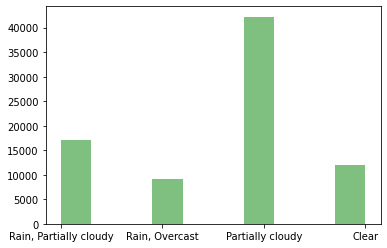

In [ ]:
#  weather condition bar graph plot
d = final.select("conditions").rdd.flatMap(lambda x: x).collect()
num_bins = 10
n, bins, patches = plt.hist(d, num_bins, facecolor='green', alpha=0.5)

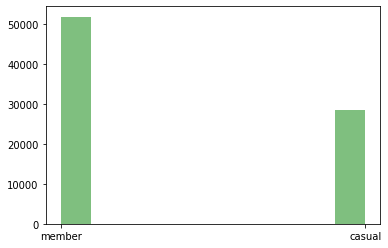

In [ ]:
#  member_casual bar graph plot
d = final.select("member_casual").rdd.flatMap(lambda x: x).collect()
num_bins = 10
n, bins, patches = plt.hist(d, num_bins, facecolor='green', alpha=0.5)


In [ ]:
# join both the data based on the day
final=df1.join(df2, df1.day == df2.w_day)

In [ ]:
### Extract day of week from date in pyspark
from pyspark.sql.functions import date_format
from pyspark.sql.functions import col
final=final.withColumn("Name_of_day", date_format(col("datetime"), "EEEE"))

In [ ]:
# number of rideable_type on given conditions
data=final.groupBy("conditions","w_day",'Name_of_day').agg({'rideable_type':'count'}).distinct()

In [ ]:
data.show(5)

+----------------+-----+-----------+--------------------+
|      conditions|w_day|Name_of_day|count(rideable_type)|
+----------------+-----+-----------+--------------------+
|Partially cloudy|   21|   Saturday|                3816|
|Partially cloudy|   05|   Thursday|                3108|
|Partially cloudy|   12|   Thursday|                2828|
|           Clear|   29|     Sunday|                3199|
|  Rain, Overcast|   13|     Friday|                2530|
+----------------+-----+-----------+--------------------+
only showing top 5 rows



In [ ]:
data=data.withColumn("weekend", lit('Blue'))

In [ ]:
data.show(5)

+----------------+-----+-----------+--------------------+-------+
|      conditions|w_day|Name_of_day|count(rideable_type)|weekend|
+----------------+-----+-----------+--------------------+-------+
|Partially cloudy|   21|   Saturday|                3816|   Blue|
|Partially cloudy|   05|   Thursday|                3108|   Blue|
|Partially cloudy|   12|   Thursday|                2828|   Blue|
|           Clear|   29|     Sunday|                3199|   Blue|
|  Rain, Overcast|   13|     Friday|                2530|   Blue|
+----------------+-----+-----------+--------------------+-------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import when
data = data.withColumn("weekend", when(data["Name_of_day"] == 'Saturday', 'Orange').otherwise(data["weekend"]))
data = data.withColumn("weekend", when(data["Name_of_day"] == 'Sunday', 'Orange').otherwise(data["weekend"]))

In [ ]:
data.show(5)

+----------------+-----+-----------+--------------------+-------+
|      conditions|w_day|Name_of_day|count(rideable_type)|weekend|
+----------------+-----+-----------+--------------------+-------+
|Partially cloudy|   21|   Saturday|                3816| Orange|
|Partially cloudy|   05|   Thursday|                3108|   Blue|
|Partially cloudy|   12|   Thursday|                2828|   Blue|
|           Clear|   29|     Sunday|                3199| Orange|
|  Rain, Overcast|   13|     Friday|                2530|   Blue|
+----------------+-----+-----------+--------------------+-------+
only showing top 5 rows



In [ ]:
data=data.sort(col("w_day").asc())

In [ ]:
a=data.select('w_day').rdd.flatMap(lambda x: x).collect()

In [ ]:
b=data.select('count(rideable_type)').rdd.flatMap(lambda x: x).collect()

In [ ]:
c=data.select('weekend').rdd.flatMap(lambda x: x).collect()

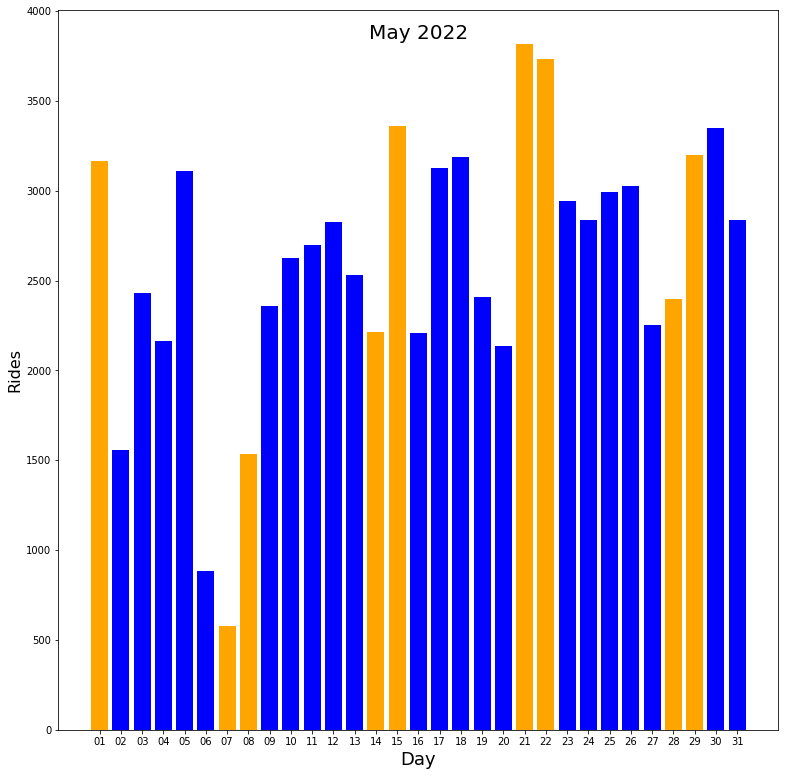

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(a,b,color=c)

fig.suptitle('May 2022', fontsize=20)
plt.xlabel('Day', fontsize=18)
plt.ylabel('Rides', fontsize=16)
fig.savefig('May 20222.jpg')
plt.show()